# Overview
Created Date : Oct 13, 2023
Goals: 
- Build an X-ray image classification model from scratch to predict whether an X-ray scan shows presence of pneumonia.  
- Improve performance of the model based on https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays/notebook#1.-Introduction-+-Set-up.  

# 1. Set up

In [3]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings(action='ignore')

## 1-1. Variables Definition

In [5]:
# Data path variables
ROOT_PATH = '/aiffel/aiffel/AIFEL_Quest/Mainquest_01/'
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*'  # * represents all directories and files.
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

# Configuration variable for fast data loading
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Variable for X-RAY image size
IMAGE_SIZE = [180, 180]

# Variable for training
BATCH_SIZE = 16
EPOCHS = 10

# 2. Data
## 2-1. Load data  
There are only 16 files in the validation folder, and we would prefer to have a less extreme division between the training and the validation set. We will append the validation files and create a new split that resembes the standard 80:20 division instead.

In [6]:
# Function : tf.io.gfile.glob
# Returns a list of files that match the given pattern(s)
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)


print("Number of files in the training dataset:", len(train_filenames))
print("Number of files in the testing dataset:", len(test_filenames))
print("Number of files in the validation dataset:", len(val_filenames))

Number of files in the training dataset: 5216
Number of files in the testing dataset: 624
Number of files in the validation dataset: 16


In [7]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)
print("Number of files in the training dataset:", len(train_filenames))
print("Number of files in the validation dataset:", len(val_filenames))

Number of files in the training dataset: 4185
Number of files in the validation dataset: 1047


## 2-2. Split data
Check the proportion of healthy (normal) and pneumonia chest X-rays

Normal images count in training set: 1102
Normal images count in training set: 3083


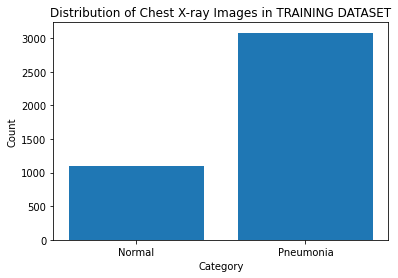

In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Normal images count in training set: " + str(PNEUMONIA))

categories = ["Normal", "Pneumonia"]
counts = [COUNT_NORMAL, PNEUMONIA]

plt.bar(categories, counts)
plt.title("Distribution of Chest X-ray Images in TRAINING DATASET")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1102
Pneumonia images count in training set: 3083


In [11]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


**NOTICE : We have a imbalance in our data, so we should consider it when we train our model.**  

## 2-3. Create label & Configure image file

In [12]:
def get_label (file_path):
    temp = tf.strings.split(file_path, os.path.sep)
    return temp[-2] == "PNEUMONIA"

In [13]:
def decode_img(img):
    # decode img to tensor format
    img = tf.image.decode_jpeg(img, channels=3)
    
    # scale down - convert to floats in the [0,1] range 
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)

In [14]:
# Return img file (converted to tensor) & label
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

## 2-4. Create dataset (train, val, test)

In [15]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


### 2-4-1. Test dataset

In [17]:
test_list_ds = tf.data.Dataset.list_files(test_filenames)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

### 2-4-2. Train, valdataset
Create more images using augmentation

#### Define & Apply augmentations

In [18]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.adjust_contrast(image, 2.5)
    return image,label

In [19]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
            augment,       
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [20]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [21]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))

## 2-5. Visualize the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

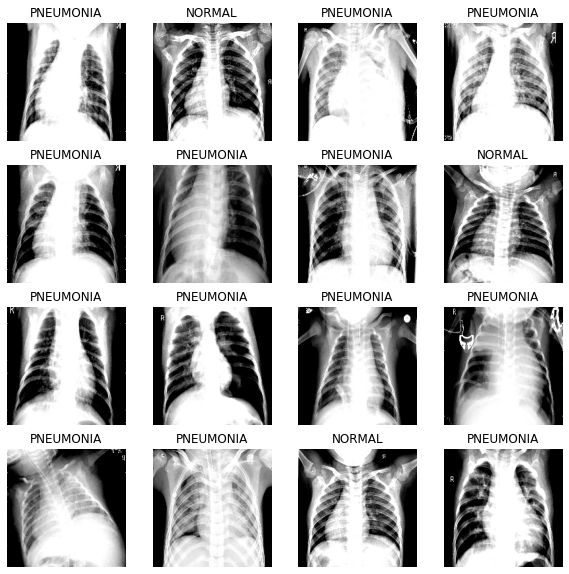

In [22]:
show_batch(image_batch.numpy(), label_batch.numpy())

# 3. Build RestNet-18

## 3-1. Build resnet class
- Order of batch normalization, batchnorm, ReLu, Dropout  
URL: https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout  

In [74]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPool2D, GlobalAveragePooling2D, Dense

def resdiual_block (x, filters):
    shortcut = Conv2D(filters, 1, padding='same')(x)
    
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])
    
    x = Activation('relu')(x)
    
    return x

def resnet_18(filters, input_shape):
    inputs = tf.keras.Input(input_shape)
    
    x = Conv2D(64, 7, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=(3, 3), strides=2)(x)
    
    for i in filters:
        x = resdiual_block(x, i)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x)
    
    return model

In [75]:
filters = [64, 128, 256, 512]

resnet_18 = resnet_18(filters, (IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

resnet_18.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 180, 180, 64) 9472        input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 180, 180, 64) 256         conv2d_30[0][0]                  
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 180, 180, 64) 0           batch_normalization_26[0][0]     
______________________________________________________________________________________________

## 3-2. Train restnet class

In [77]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.67


In [80]:
with tf.device('/GPU:0'):
    model = resnet_18

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    
model.save('PNEUMONIA_classifier_01.h5')

Epoch 1/10
261/261 [==============================] - 222s 599ms/step - loss: 0.3422 - accuracy: 0.8594 - precision: 0.9517 - recall: 0.8536 - val_loss: 2.6651 - val_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 153s 587ms/step - loss: 0.3249 - accuracy: 0.8693 - precision: 0.9557 - recall: 0.8637 - val_loss: 85.9443 - val_accuracy: 0.2529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
261/261 [==============================] - 156s 598ms/step - loss: 0.2493 - accuracy: 0.8997 - precision: 0.9665 - recall: 0.8957 - val_loss: 3.6058 - val_accuracy: 0.4019 - val_precision: 1.0000 - val_recall: 0.1985
Epoch 4/10
261/261 [==============================] - 157s 601ms/step - loss: 0.1853 - accuracy: 0.9298 - precision: 0.9762 - recall: 0.9280 - val_loss: 53.7202 - val_accuracy: 0.2558 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
261/261 [==============================] - 157s 601ms/step 

## 3-3. Check result 

39/39 [==============================] - 6s 159ms/step - loss: 1.4209 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.4209314584732056,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


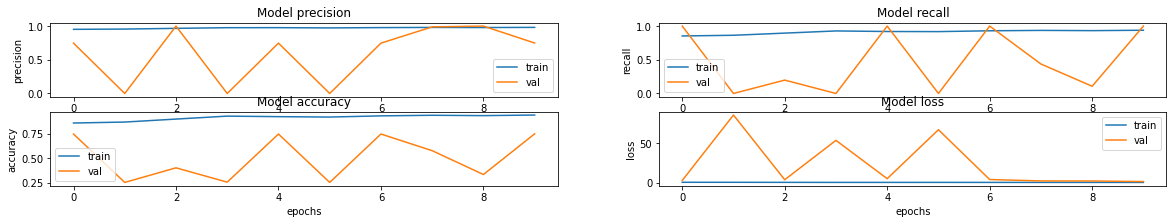

In [83]:
fig, ax = plt.subplots(2, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

## 3-4. Modify learning rate
We also want to finetune our learning rate. Too high of a learning rate will cause the model to diverge. Too small of a learning rate will cause the model to be too slow. We implement the exponential learning rate scheduling method below.

In [97]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("PNEUMONIA_classifier_02.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [98]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/100
261/261 [==============================] - 153s 559ms/step - loss: 0.4349 - accuracy: 0.8216 - precision: 0.9326 - recall: 0.8205 - val_loss: 0.9592 - val_accuracy: 0.7221 - val_precision: 0.7221 - val_recall: 1.0000
Epoch 2/100
261/261 [==============================] - 150s 574ms/step - loss: 0.3332 - accuracy: 0.8683 - precision: 0.9499 - recall: 0.8695 - val_loss: 1.1298 - val_accuracy: 0.7221 - val_precision: 0.7221 - val_recall: 1.0000
Epoch 3/100
261/261 [==============================] - 151s 578ms/step - loss: 0.2725 - accuracy: 0.8956 - precision: 0.9618 - recall: 0.8958 - val_loss: 0.5503 - val_accuracy: 0.7404 - val_precision: 0.7358 - val_recall: 1.0000
Epoch 4/100
261/261 [==============================] - 150s 575ms/step - loss: 0.2848 - accuracy: 0.8903 - precision: 0.9568 - recall: 0.8936 - val_loss: 0.6790 - val_accuracy: 0.7346 - val_precision: 0.7318 - val_recall: 1.0000
Epoch 5/100
261/261 [==============================] - 149s 572ms/step - loss: 0.255

In [1]:
from keras.models import load_model
model = load_model('PNEUMONIA_classifier_02.h5')

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 1063s 27s/step - loss: 2.2604 - accuracy: 0.6587 - precision: 0.6468 - recall: 1.0000
Loss: 2.260432720184326,
Accuracy: 0.6586538553237915,
Precision: 0.646766185760498,
Recall: 1.0
